In [1]:
import jax
import jax.numpy as jnp
import ott
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# -- 1. Create two 256x256 images --
IMG_SIZE = 256
GRID_COORDS = jnp.linspace(0, 1, IMG_SIZE)
xx, yy = jnp.meshgrid(GRID_COORDS, GRID_COORDS)
coords = jnp.stack([xx.ravel(), yy.ravel()]).T

def create_gaussian_blob(center, sigma=0.1):
    """Creates a 2D Gaussian blob on the grid."""
    dist_sq = jnp.sum((coords - jnp.array(center))**2, axis=-1)
    blob = jnp.exp(-dist_sq / (2 * sigma**2))
    return blob.reshape(IMG_SIZE, IMG_SIZE)

# Create two blobs at different locations
img_a = create_gaussian_blob([0.25, 0.25])
img_b = create_gaussian_blob([0.75, 0.75])

# Normalize them to be probability distributions
img_a = img_a / jnp.sum(img_a)
img_b = img_b / jnp.sum(img_b)


In [3]:
# -- 2. Define and solve the OT problem --

# a. Define the geometry using the corrected `grid_size` parameter.
# The Grid geometry implicitly handles the problem using convolutions (FFT).
geom = ott.geometry.grid.Grid(grid_size=(IMG_SIZE, IMG_SIZE), epsilon=5e-3)

# b. Define the linear problem with flattened images.
ot_problem = ott.problems.linear.linear_problem.LinearProblem(
    geom=geom, a=img_a.ravel(), b=img_b.ravel()
)


In [4]:
# c. Define the Sinkhorn solver.
solver = ott.solvers.linear.sinkhorn.Sinkhorn()

# d. Solve the problem.
solution = solver(ot_problem)

In [5]:
# -- 3. Get the results --
f_potential = solution.f.reshape(IMG_SIZE, IMG_SIZE)
g_potential = solution.g.reshape(IMG_SIZE, IMG_SIZE)
ot_cost = jnp.sum(f_potential * img_a) + jnp.sum(g_potential * img_b)

Optimal Transport Cost: 0.4128
Shape of f potential: (256, 256)


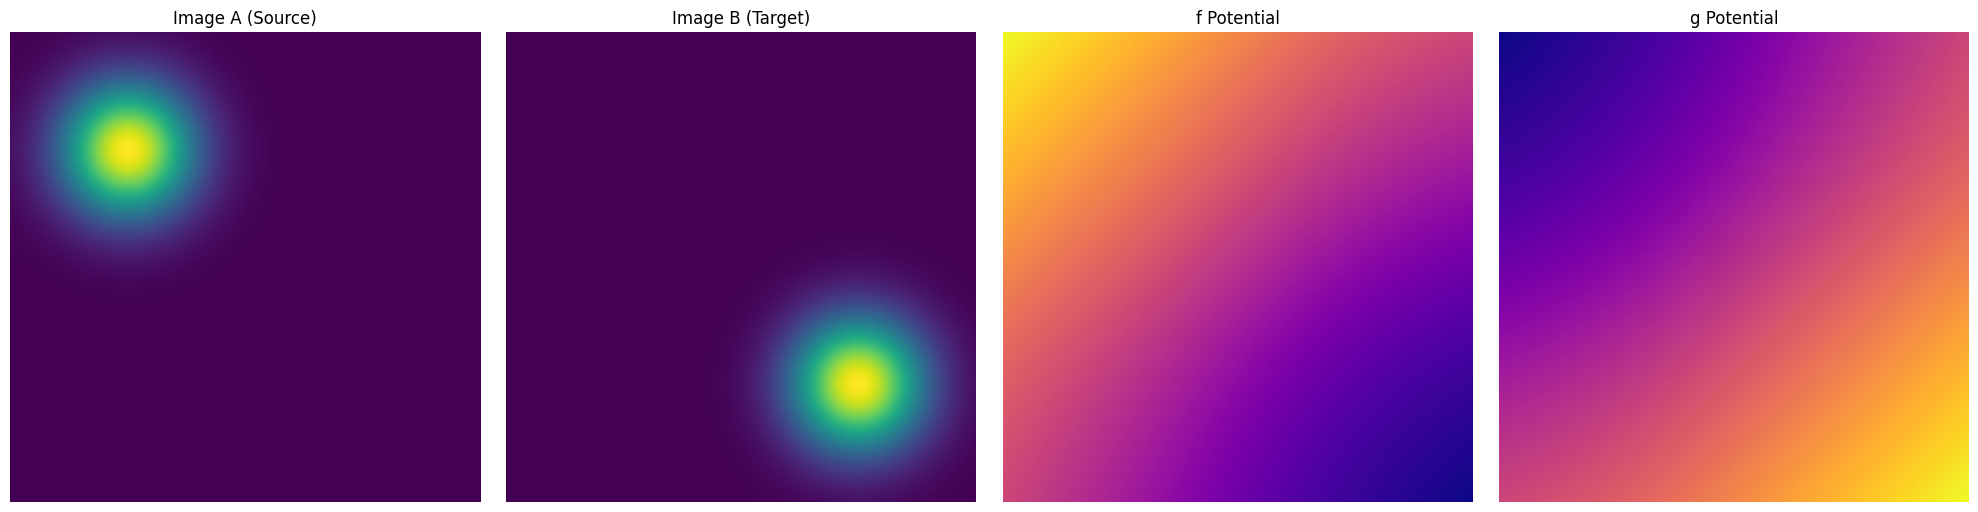

In [13]:
print(f"Optimal Transport Cost: {ot_cost:.4f}")
print(f"Shape of f potential: {f_potential.shape}")

# -- 4. Visualize the inputs and potentials --
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(np.asarray(img_a), cmap='viridis')
axs[0].set_title('Image A (Source)')
axs[0].axis('off')

axs[1].imshow(np.asarray(img_b), cmap='viridis')
axs[1].set_title('Image B (Target)')
axs[1].axis('off')

axs[2].imshow(np.asarray(f_potential), cmap='plasma')
axs[2].set_title('f Potential')
axs[2].axis('off')

axs[3].imshow(np.asarray(g_potential), cmap='plasma')
axs[3].set_title('g Potential')
axs[3].axis('off')

plt.tight_layout()
plt.show()